## Background

Selected molecular descriptors from the Dragon chemoinformatics application were used to predict bioconcentration factors for 779 chemicals in order to evaluate QSAR (Quantitative Structure Activity Relationship).  This dataset was obtained from the UCI machine learning repository.

The dataset consists of 779 observations of 10 attributes. Below is a brief description of each feature and the response variable (logBCF) in our dataset:

1. *nHM* - number of heavy atoms (integer)
2. *piPC09* - molecular multiple path count (numeric)
3. *PCD* - difference between multiple path count and path count (numeric)
4. *X2Av* - average valence connectivity (numeric)
5. *MLOGP* - Moriguchi octanol-water partition coefficient (numeric)
6. *ON1V* -  overall modified Zagreb index by valence vertex degrees (numeric)
7. *N.072* - Frequency of RCO-N< / >N-X=X fragments (integer)
8. *B02[C-N]* - Presence/Absence of C-N atom pairs (binary)
9. *F04[C-O]* - Frequency of C-O atom pairs (integer)
10. *logBCF* - Bioconcentration Factor in log units (numeric)

Note that all predictors with the exception of B02[C-N] are quantitative.  For the purpose of this assignment, DO NOT CONVERT B02[C-N] to factor.  Leave the data in its original format - numeric in R.

Please load the dataset "Bio_pred" and then split the dataset into a train and test set in a 80:20 ratio.

Please make sure that you are using R version 3.6.X or above (i.e. version 4.X is also acceptable).

## Read Data

In [1]:
install.packages("https://cran.r-project.org/src/contrib/Archive/CombMSC/CombMSC_1.4.2.1.tar.gz")
install.packages("leaps")
install.packages("Rcpp", dependencies=TRUE)

inferring 'repos = NULL' from 'pkgs'




The downloaded binary packages are in
	/var/folders/nz/69j_kvq566n6khx_x3dz6y000000gn/T//RtmpwONsaS/downloaded_packages


also installing the dependencies ‘rbenchmark’, ‘pkgKitten’





The downloaded binary packages are in
	/var/folders/nz/69j_kvq566n6khx_x3dz6y000000gn/T//RtmpwONsaS/downloaded_packages


In [25]:
# Clear variables in memory
rm(list=ls())

# Import the libraries
library(CombMSC)
library(boot)
library(leaps)
library(MASS)
library(glmnet)

# Ensure that the sampling type is correct
RNGkind(sample.kind="Rejection")

# Set a seed for reproducibility
set.seed(100)

# Read data
fullData = read.csv("Bio_pred.csv",header=TRUE)

# Split data for traIning and testing
testRows = sample(nrow(fullData),0.2*nrow(fullData))
testData = fullData[testRows, ]
trainData = fullData[-testRows, ]

Note: Use the training set to build the models in Questions 1-6. Use the test set to help evaluate model performance in Question 7.

## Question 1: Full Model

(a) Fit a multiple linear regression with the variable *logBCF* as the response and the other variables as predictors. Call it *model1*. Display the model summary.

In [34]:
model1 = lm(logBCF~., data=trainData)
summary(model1)


Call:
lm(formula = logBCF ~ ., data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2577 -0.5180  0.0448  0.5117  4.0423 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.001422   0.138057   0.010  0.99179    
nHM          0.137022   0.022462   6.100 1.88e-09 ***
piPC09       0.031158   0.020874   1.493  0.13603    
PCD          0.055655   0.063874   0.871  0.38391    
X2Av        -0.031890   0.253574  -0.126  0.89996    
MLOGP        0.506088   0.034211  14.793  < 2e-16 ***
ON1V         0.140595   0.066810   2.104  0.03575 *  
N.072       -0.073334   0.070993  -1.033  0.30202    
B02.C.N.    -0.158231   0.080143  -1.974  0.04879 *  
F04.C.O.    -0.030763   0.009667  -3.182  0.00154 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7957 on 614 degrees of freedom
Multiple R-squared:  0.6672,	Adjusted R-squared:  0.6623 
F-statistic: 136.8 on 9 and 614 DF,  p-value: < 2.2e-16


(b) Which regression coefficients are significant at the 95% confidence level? At the 99% confidence level?

95%: nHM, MLOGP, ON1V, P02.C.N., F04.C.O
99%: nHM, MLOGP, F04.C.O

(c) What are the Mallow's Cp, AIC, and BIC criterion values for this model?

In [35]:
set.seed(100)

n = nrow(trainData)

cp <- Cp(model1, S2=summary(model1)$sigma^2)
aic <- AIC(model1, k=2)
bic <- AIC(model1, k=log(n))
data.frame(MallowsCp=cp, AIC=aic, BIC=bic)


MallowsCp,AIC,BIC
<dbl>,<dbl>,<dbl>
10,1497.477,1546.274


(d) Build a new model on the training data with only the variables which coefficients were found to be statistically significant at the 99% confidence level. Call it *model2*. Perform a Partial F-test to compare this new model (*model2*) with the full model (*model1*). Which one would you prefer? Is it good practice to select variables based on statistical significance of individual coefficients? Explain.

In [36]:
set.seed(100)

model2 = lm(logBCF~nHM+MLOGP+F04.C.O., data=trainData)
anova(model2, model1)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,620,400.5136,NA,NA,NA,NA
2,614,388.7043,6,11.80928,3.109002,0.005230363


The p-value is $\approx 0$ therefore we reject the null hypothesis of the reduced model and conclude that additional variables in the full model are useful. It is not good practice to select variables based on statistical signficance. More advanced preditor selection methods should be used to eliminate predictors.

## Question 2: Full Model Search

(a) Compare all possible models using Mallow's Cp. What is the total number of possible models with the full set of variables? Display a table indicating the variables included in the best model of each size and the corresponding Mallow's Cp value. 

Hint: You can use nbest parameter. 

In [37]:
set.seed(100)

out = leaps(trainData[,-c(10)], trainData$logBCF, method="Cp")
cbind(as.matrix(out$which), out$Cp)

,1,2,3,4,5,6,7,8,9,
1,0,0,0,0,1,0,0,0,0,58.596851
1,1,0,0,0,0,0,0,0,0,821.003439
1,0,1,0,0,0,0,0,0,0,875.911282
1,0,0,1,0,0,0,0,0,0,986.721460
1,0,0,0,0,0,0,0,1,0,1004.917654
1,0,0,0,0,0,0,1,0,0,1156.059904
1,0,0,0,0,0,1,0,0,0,1180.996680
1,0,0,0,0,0,0,0,0,1,1192.010393
1,0,0,0,1,0,0,0,0,0,1220.973066
2,1,0,0,0,1,0,0,0,0,17.737801


(b) How many variables are in the model with the lowest Mallow's Cp value? Which variables are they? Fit this model and call it *model3*. Display the model summary.

In [38]:
set.seed(100)

best.model = which(out$Cp==min(out$Cp))
cbind(as.matrix(out$which), out$Cp)[best.model,]

print("6 variables were chosen for the model with the lowest cp and they are:")
names(trainData[c(1, 2, 5, 6, 8, 9)])

model3 = lm(logBCF~nHM+piPC09+MLOGP+ON1V+B02.C.N.+F04.C.O., data=trainData)
summary(model3)

1        2        3        4        5        6        7        8 
1.000000 1.000000 0.000000 0.000000 1.000000 1.000000 0.000000 1.000000 
       9          
1.000000 6.116174

[1] "6 variables were chosen for the model with the lowest cp and they are:"


[1] "nHM"      "piPC09"   "MLOGP"    "ON1V"     "B02.C.N." "F04.C.O."


Call:
lm(formula = logBCF ~ nHM + piPC09 + MLOGP + ON1V + B02.C.N. + 
    F04.C.O., data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2364 -0.5234  0.0421  0.5196  4.1159 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.035785   0.099454   0.360  0.71911    
nHM          0.124086   0.019083   6.502 1.63e-10 ***
piPC09       0.042167   0.014135   2.983  0.00297 ** 
MLOGP        0.528522   0.029434  17.956  < 2e-16 ***
ON1V         0.098099   0.055457   1.769  0.07740 .  
B02.C.N.    -0.160204   0.073225  -2.188  0.02906 *  
F04.C.O.    -0.028644   0.009415  -3.042  0.00245 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7951 on 617 degrees of freedom
Multiple R-squared:  0.666,	Adjusted R-squared:  0.6628 
F-statistic: 205.1 on 6 and 617 DF,  p-value: < 2.2e-16


## Question 3: Stepwise Regression

(a) Perform backward stepwise regression using BIC. Allow the minimum model to be the model with only an intercept, and the full model to be *model1*. Display the model summary of your final model. Call it *model4*

In [39]:
set.seed(100)
n=nrow(trainData)
model4 <- step(model1, scope = list(lower= lm(logBCF~1, data=trainData), upper=model1), direction="backward", k=log(n))

summary(model4)

Start:  AIC=-231
logBCF ~ nHM + piPC09 + PCD + X2Av + MLOGP + ON1V + N.072 + B02.C.N. + 
    F04.C.O.

           Df Sum of Sq    RSS      AIC
- X2Av      1     0.010 388.71 -237.417
- PCD       1     0.481 389.18 -236.662
- N.072     1     0.676 389.38 -236.350
- piPC09    1     1.411 390.11 -235.173
- B02.C.N.  1     2.468 391.17 -233.484
- ON1V      1     2.804 391.51 -232.949
<none>                  388.70 -230.997
- F04.C.O.  1     6.410 395.11 -227.226
- nHM       1    23.557 412.26 -200.718
- MLOGP     1   138.539 527.24  -47.211

Step:  AIC=-237.42
logBCF ~ nHM + piPC09 + PCD + MLOGP + ON1V + N.072 + B02.C.N. + 
    F04.C.O.

           Df Sum of Sq    RSS      AIC
- PCD       1     0.517 389.23 -243.025
- N.072     1     0.667 389.38 -242.783
- piPC09    1     1.423 390.14 -241.574
- B02.C.N.  1     2.510 391.22 -239.838
- ON1V      1     2.915 391.63 -239.192
<none>                  388.71 -237.417
- F04.C.O.  1     6.491 395.21 -233.520
- nHM       1    25.431 414.15 -204.30


Call:
lm(formula = logBCF ~ nHM + piPC09 + MLOGP + F04.C.O., data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2611 -0.5126  0.0517  0.5353  4.3488 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.008695   0.078196  -0.111  0.91150    
nHM          0.114029   0.017574   6.489 1.78e-10 ***
piPC09       0.041119   0.013636   3.015  0.00267 ** 
MLOGP        0.566473   0.025990  21.796  < 2e-16 ***
F04.C.O.    -0.022104   0.008000  -2.763  0.00590 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7985 on 619 degrees of freedom
Multiple R-squared:  0.662,	Adjusted R-squared:  0.6599 
F-statistic: 303.1 on 4 and 619 DF,  p-value: < 2.2e-16


(b) How many variables are in *model4*? Which regression coefficients are significant at the 99% confidence level?


There are 4 variables in model4. All regression coefficients (nHL, piPC09, MLOGP, F04.C.O.) except for the intercept are statistically significant at 99% confidence interval. 

(c) Perform forward stepwise selection with AIC. Allow the minimum model to be the model with only an intercept, and the full model to be *model1*. Display the model summary of your final model. Call it *model5*. Do the variables included in *model5* differ from the variables in *model4*? 


In [40]:
set.seed(100)

n=nrow(trainData)
model5 <- step(lm(logBCF~1, data=trainData), scope = list(lower= lm(logBCF~1, data=trainData), upper=model1), direction="forward")

summary(model5)

Start:  AIC=393.14
logBCF ~ 1

           Df Sum of Sq     RSS     AIC
+ MLOGP     1    738.32  429.60 -228.94
+ nHM       1    255.66  912.25  240.98
+ piPC09    1    220.90  947.02  264.31
+ PCD       1    150.75 1017.17  308.90
+ B02.C.N.  1    139.23 1028.68  315.93
+ N.072     1     43.55 1124.37  371.43
+ ON1V      1     27.76 1140.16  380.13
+ F04.C.O.  1     20.79 1147.13  383.93
<none>                  1167.92  393.14
+ X2Av      1      2.45 1165.46  393.83

Step:  AIC=-228.94
logBCF ~ MLOGP

           Df Sum of Sq    RSS     AIC
+ nHM       1   27.1327 402.47 -267.65
+ B02.C.N.  1    4.1778 425.42 -233.04
+ F04.C.O.  1    4.1526 425.45 -233.00
+ X2Av      1    3.2819 426.32 -231.72
+ ON1V      1    2.3664 427.23 -230.38
<none>                  429.60 -228.94
+ piPC09    1    1.0443 428.55 -228.46
+ N.072     1    0.2481 429.35 -227.30
+ PCD       1    0.1198 429.48 -227.11

Step:  AIC=-267.65
logBCF ~ MLOGP + nHM

           Df Sum of Sq    RSS     AIC
+ piPC09    1   2.8824


Call:
lm(formula = logBCF ~ MLOGP + nHM + piPC09 + F04.C.O. + B02.C.N. + 
    ON1V, data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2364 -0.5234  0.0421  0.5196  4.1159 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.035785   0.099454   0.360  0.71911    
MLOGP        0.528522   0.029434  17.956  < 2e-16 ***
nHM          0.124086   0.019083   6.502 1.63e-10 ***
piPC09       0.042167   0.014135   2.983  0.00297 ** 
F04.C.O.    -0.028644   0.009415  -3.042  0.00245 ** 
B02.C.N.    -0.160204   0.073225  -2.188  0.02906 *  
ON1V         0.098099   0.055457   1.769  0.07740 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7951 on 617 degrees of freedom
Multiple R-squared:  0.666,	Adjusted R-squared:  0.6628 
F-statistic: 205.1 on 6 and 617 DF,  p-value: < 2.2e-16


Yes, the variables chosen using forward regression are different than those in backward regression.

(d) Compare the adjusted $R^2$, Mallow's Cp, AICs and BICs of the full model (*model1*), the model found in Question 2 (*model3*), and the model found using backward selection with BIC (*model4*). Which model is preferred based on these criteria and why?

In [41]:
set.seed(100)

c("Model", "Adjust R2", "Cp", "AIC", "BIC")
c("model1", round(summary(model1)$adj.r.squared, 3), round(Cp(model1, S2=summary(model1)$sigma^2), 3), round(AIC(model1, k=2),3), round(AIC(model1, k=log(n)), 3))
c("model3", round(summary(model3)$adj.r.squared, 3), round(Cp(model3, S2=summary(model3)$sigma^2), 3), round(AIC(model3, k=2),3), round(AIC(model3, k=log(n)), 3))
c("model4", round(summary(model4)$adj.r.squared, 3), round(Cp(model4, S2=summary(model4)$sigma^2), 3), round(AIC(model4, k=2),3), round(AIC(model4, k=log(n)), 3))

[1] "Model"     "Adjust R2" "Cp"        "AIC"       "BIC"

[1] "model1"   "0.662"    "10"       "1497.477" "1546.274"

[1] "model3"   "0.663"    "7"        "1493.623" "1529.113"

[1] "model4"   "0.66"     "5"        "1497.052" "1523.669"

Based on this criteria it is difficult to choose between model3 and model4. Model3 has the highest adjust r-squred signifying it describes the variation in the predictior the most. However model4 has a lower mallows cp and BIC. An additional criteria could be the simplicity of the model where model4 is simpler with 4 predictors while model3 has 6.



## Question 4: Ridge Regression

(a) Perform ridge regression on the training set. Use cv.glmnet() to find the lambda value that minimizes the cross-validation error using 10 fold CV.

In [42]:
set.seed(100)

ridge = cv.glmnet(x=as.matrix(trainData[,-10]), y=trainData$logBCF, alpha=0, nfolds=10)


(b) List the value of coefficients at the optimum lambda value.

In [43]:
set.seed(100)
coef(ridge, s=ridge$lambda.min)

10 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.13841426
nHM          0.14391877
piPC09       0.03735762
PCD          0.08235334
X2Av        -0.06901352
MLOGP        0.44403654
ON1V         0.15770114
N.072       -0.09683534
B02.C.N.    -0.20919397
F04.C.O.    -0.03177144

(c) How many variables were selected? Was this result expected? Explain.

All 9 variables were selected using this method. This is not surprising because ridge regression does not do variable selection.

## Question 5: Lasso Regression

(a) Perform lasso regression on the training set.Use cv.glmnet() to find the lambda value that minimizes the cross-validation error using 10 fold CV.

In [44]:
set.seed(100)
lasso = cv.glmnet(x=as.matrix(trainData[,-10]), y=trainData$logBCF, alpha=1, nfolds=10)

(b) Plot the regression coefficient path.

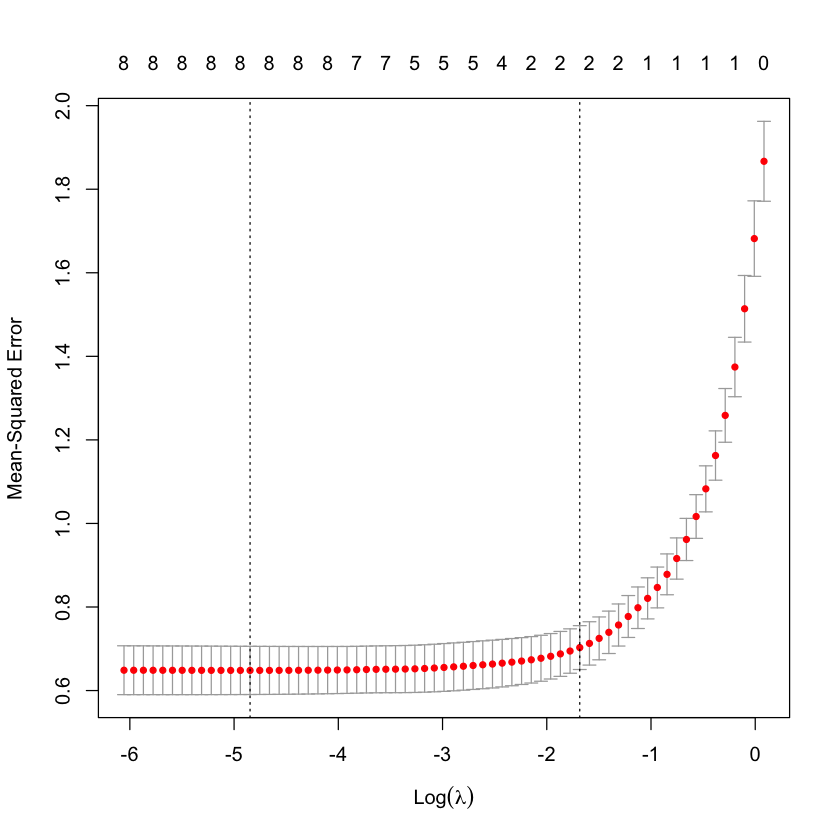

In [45]:
set.seed(100)
plot(lasso)

(c) How many variables were selected? Which are they?

In [46]:
set.seed(100)
coef(lasso, s=lasso$lambda.min)

10 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.02722838
nHM          0.12543866
piPC09       0.03387665
PCD          0.03194878
X2Av         .         
MLOGP        0.52174346
ON1V         0.09633951
N.072       -0.05487196
B02.C.N.    -0.13961811
F04.C.O.    -0.02535576

8 variables were selected. They include nHM, piPC09, PCD, MLOGP, ON1V, N.072, B02.C.N., F04.C.O.

## Question 6: Elastic Net

(a) Perform elastic net regression on the training set. Use cv.glmnet() to find the lambda value that minimizes the cross-validation error using 10 fold CV. Give equal weight to both penalties.

In [47]:
set.seed(100)

en = cv.glmnet(x=as.matrix(trainData[,-10]), y=trainData$logBCF, alpha=0.5, nfolds=10)

(b) List the coefficient values at the optimal lambda. How many variables were selected? How do these variables compare to those from Lasso in Question 5?

In [48]:
set.seed(100)
coef(en, s=en$lambda.min)

10 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept)  0.04903516
nHM          0.12397290
piPC09       0.03470891
PCD          0.03060034
X2Av         .         
MLOGP        0.51776470
ON1V         0.08901088
N.072       -0.05236840
B02.C.N.    -0.14155538
F04.C.O.    -0.02420217

8 variables were selected. They were the same as those found in lasso regression in Question 5.

## Question 7: Model comparison

(a) Predict *logBCF* for each of the rows in the test data using the full model, and the models found using backward stepwise regression with BIC, ridge regression, lasso regression, and elastic net. Display the first few predictions for each model.

In [66]:
set.seed(100)

pred.model1 = predict(model1, newdata = testData, type = "response")
pred.model4 = predict(model4, newdata = testData, type = "response")
pred.ridge = predict(ridge, newx = as.matrix(testData)[, -10], type = "response")
pred.lasso = predict(lasso, newx = as.matrix(testData)[, -10], type = "response")
pred.en = predict(en, newx = as.matrix(testData)[, -10], type = "response")


print("Predictions using model1")
pred.model1[c(1, 2, 3)]

print("Predictions using model4")
pred.model4[c(1, 2, 3)]

print("Predictions using ridge")
pred.ridge[c(1, 2, 3)]

print("Predictions using lasso")
pred.lasso[c(1, 2, 3)]

print("Predictions using en")
pred.en[c(1, 2, 3)]

[1] "Predictions using model1"


714      503      358 
2.446479 4.333759 3.266892

[1] "Predictions using model4"


714      503      358 
2.424916 4.353167 3.274192

[1] "Predictions using ridge"


[1] 2.459823 3.912997 3.082469

[1] "Predictions using lasso"


[1] 2.346113 3.834118 3.010261

[1] "Predictions using en"


[1] 2.302663 3.857681 2.989613

(b) Compare the predictions using mean squared prediction error. Which model performed the best?

In [71]:
set.seed(100)
mean(model1$residuals^2)
mean(model4$residuals^2)
min(ridge$cvm)
min(lasso$cvm)
min(en$cvm)

[1] 0.6229236

[1] 0.6325567

[1] 0.649911

[1] 0.6482057

[1] 0.6477885

The full model has the lowest mean squared prediction error.

(c) Provide a table listing each method described in Question 7a and the variables selected by each method (see Lesson 5.8 for an example). Which variables were selected consistently?


|        | Backward Stepwise | Ridge | Lasso  | Elastic Net |
|--------|-------------|-------------------|--------|-------|
|nHM     |        X    |             X     |    X   |   X   |          
|piPC09  |        X    |             X     |    X   |   X   | 
|PCD     |             |             X     |    X   |   x   |        
|X2AV    |             |             X     |        |       | 
|MLOGP   |        X    |             X     |    X   |   X   | 
|ON1V    |             |             X     |    X   |   X   | 
|N.072   |             |             X     |    X   |   X   | 
|B02.C.N.|             |             X     |    X   |   X   |
|F04.C.O.|        X    |             X     |    X   |   X   | 
